<a href="https://colab.research.google.com/github/mseoulum/AIFFEL_Quest/blob/main/Finance_Time_Series_Data_%ED%99%9C%EC%9A%A9%ED%95%98%EA%B8%B0(240730).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Data Labeling
- Price Change Direction 적용하기
- Using Moving Average 적용하기
- Local Min-max 적용하기
- Trend Sacanning 적용하기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

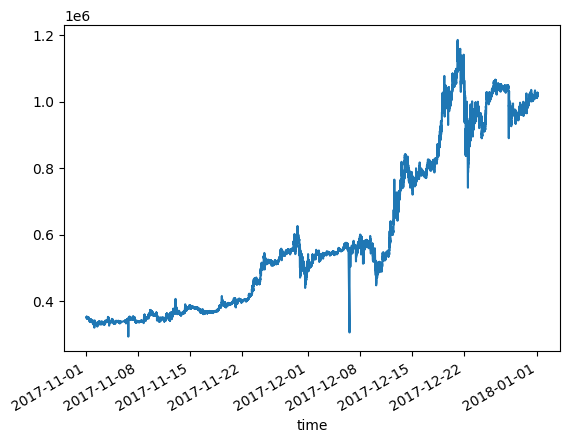

In [2]:
# 데이터 경로
DATA_PATH = '/content/drive/MyDrive/Aiffel'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

## 1.Price Change Direction 적용하기

In [3]:
# window 지정
window = 10

# momentum_signal 만들기
# momentum_signal = np.sign(np.sign('[[YOUR CODE]]') + 1) # modify_data['close'].shift(window)활용
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # 데이터 활용을 위해 pd.Series를 사용합니다.

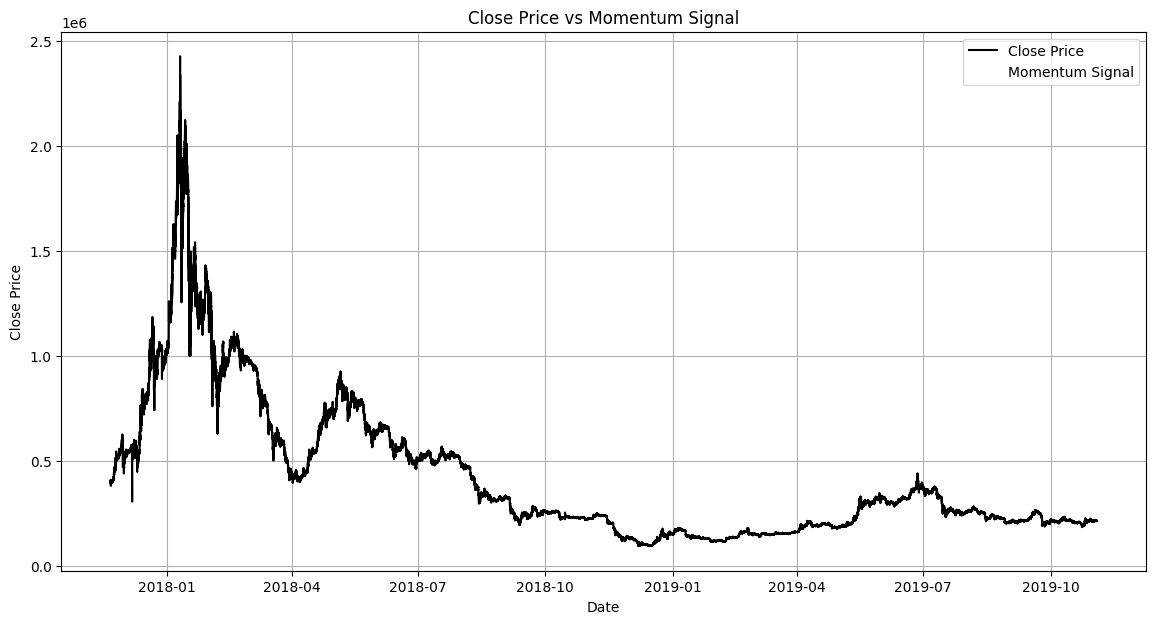

In [4]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':, 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21':] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig = pd.DataFrame(c_sig, columns=['momentum_signal'])
c_sig['color'] = np.where(c_sig['momentum_signal'] == 2, 'g',
                          np.where(c_sig['momentum_signal'] == 0, 'r', 'b'))

# 시각화하기
plt.figure(figsize=(14, 7))
plt.plot(sub_data.index, sub_data, label='Close Price', color='black')
plt.scatter(c_sig.index, sub_data.loc[c_sig.index], c=c_sig['color'], label='Momentum Signal', marker='o')
plt.title('Close Price vs Momentum Signal')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## 2.Using Moving Average 적용하기

In [5]:
# momentum_signal
window = 10
# momentum_signal = np.sign(np.sign('[[YOUR CODE]]') + 1) # modify_data['close'].rolling(window).mean() 활용
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # pd.Series로 변환

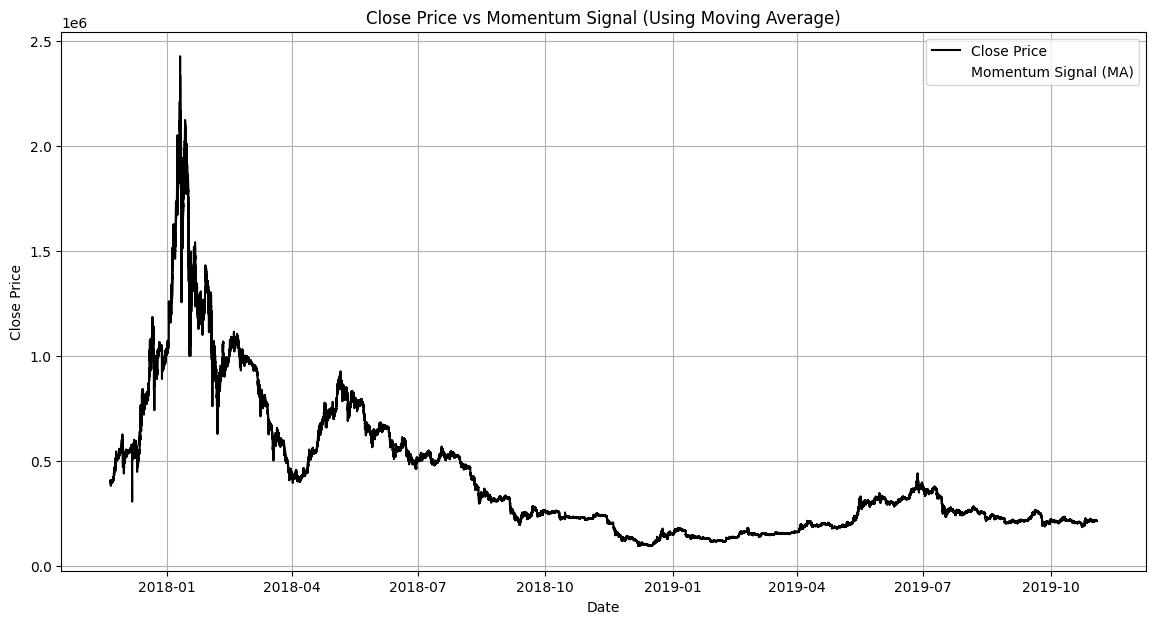

In [6]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':, 'close']

# 수식 적용된 데이터 만들기
c_sig_ma = s_momentum_signal.loc['2017-11-21':]

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig_ma = pd.DataFrame(c_sig_ma, columns=['momentum_signal'])
c_sig_ma['color'] = np.where(c_sig_ma['momentum_signal'] == 2, 'g',
                             np.where(c_sig_ma['momentum_signal'] == 0, 'r', 'b'))

# 시각화하기
plt.figure(figsize=(14, 7))
plt.plot(sub_data.index, sub_data, label='Close Price', color='black')
plt.scatter(c_sig_ma.index, sub_data.loc[c_sig_ma.index], c=c_sig_ma['color'], label='Momentum Signal (MA)', marker='o')
plt.title('Close Price vs Momentum Signal (Using Moving Average)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## 3.Local Min-Max 적용하기

In [7]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max += 1 # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0

    return {
        'mins': pd.DataFrame({'min_value': mins, 'min_index': min_idxes}),
        'maxes': pd.DataFrame({'max_value': maxes, 'max_index': max_idxes})
    } # ⑧

In [8]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인
print(mins)
print('--'*20)
print(maxes)

mins
----------------------------------------
maxes


In [9]:
# 함수 호출
local_extremes = get_local_min_max(modify_data['close'], wait=3)

# min과 maxes 값 확인
mins_df = local_extremes['mins']
maxes_df = local_extremes['maxes']

# 출력
print("Local Minima:")
print(mins_df.head())  # 처음 몇 개의 지역 최소값 확인
print("\nLocal Maxima:")
print(maxes_df.head())  # 처음 몇 개의 지역 최대값 확인

Local Minima:
   min_value           min_index
0     323000 2017-09-25 03:07:00
1     322500 2017-09-25 03:20:00
2     321500 2017-09-25 03:22:00
3     323000 2017-09-25 03:32:00
4     322500 2017-09-25 03:40:00

Local Maxima:
   max_value           max_index
0     324500 2017-09-25 03:02:00
1     324500 2017-09-25 03:12:00
2     323500 2017-09-25 03:27:00
3     324000 2017-09-25 03:36:00
4     324500 2017-09-25 03:42:00


In [10]:
# Local mins, maxes를 확인
local_extremes = get_local_min_max(sub_data, wait=3)
mins = local_extremes['mins']
maxes = local_extremes['maxes']

In [11]:
# mins, maxes 확인
print(mins)
print('--'*20)
print(maxes)

        min_value           min_index
0          399050 2017-11-21 00:01:00
1          399000 2017-11-21 00:03:00
2          398900 2017-11-21 00:04:00
3          398850 2017-11-21 00:05:00
4          398800 2017-11-21 00:06:00
...           ...                 ...
293188     212700 2019-11-03 10:26:00
293189     212600 2019-11-03 10:30:00
293190     212400 2019-11-03 10:31:00
293191     212500 2019-11-03 10:32:00
293192     212350 2019-11-03 10:33:00

[293193 rows x 2 columns]
----------------------------------------
        max_value           max_index
0          399500 2017-11-21 00:13:00
1          399900 2017-11-21 00:14:00
2          401450 2017-11-21 00:16:00
3          401350 2017-11-21 00:19:00
4          401500 2017-11-21 00:20:00
...           ...                 ...
236563     213650 2019-11-03 09:54:00
236564     213750 2019-11-03 10:03:00
236565     213400 2019-11-03 10:12:00
236566     213550 2019-11-03 10:13:00
236567     212800 2019-11-03 10:29:00

[236568 rows x 2 co

(91545.3, 2453290.0)

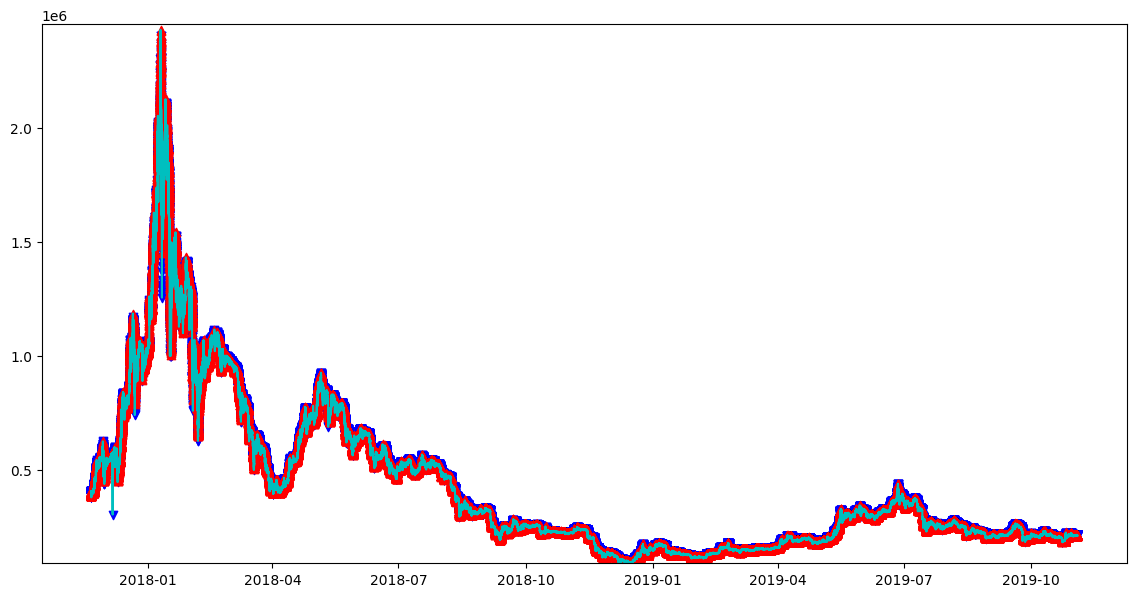

In [12]:
# subplots 및 plot 생성
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(sub_data, 'c', label='Close Price')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins['min_index'], mins['min_value'], color='blue', marker='v', label='Local Minima')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes['max_index'], maxes['max_value'], color='red', marker='^', label='Local Maxima')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max() * 1.01])

## 4.Trend Scanning 적용

In [13]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [14]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [15]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df))  # t-value 사용

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out, dtype=object)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [27:09<00:00, 20.49it/s]


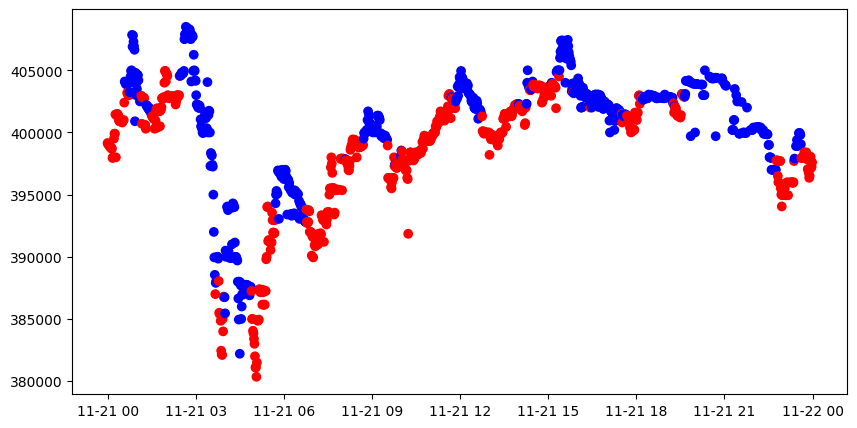

In [17]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# 2.Feature Engineering
- 환경구성 및 데이터 불러오기
- Technical Index 적용하기
- Feature Selection methods 적용하기

## 1.환경구성 및 데이터 불러오기

In [18]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28896 sha256=42f05f4afb208a206f3384fa0d443070a82030ef9ea0910213f19e3f7e7ab073
  Stored in directory: /root/.cache/pip/wheels/b7/65/0e/3d1bb888bc1bd2cdfb6d7f025fd9d0b44ca4873e27f8bb369e
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.6 MB/s eta 0:00:00


In [19]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/content/drive/MyDrive/Aiffel')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [20]:
# 데이터 경로 설정
DATA_PATH = '/content/drive/MyDrive/Aiffel'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

## 2.Technical Index 적용하기

In [21]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [22]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [23]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1]
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [24]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(random_state=42)

## 3.Feature Selection methods 적용하기

### MDI, Mean Decrease Impurity

In [25]:
# MDI, Mean Decrease Impurity
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.039110,0.001788
volume_fi,0.041509,0.002297
volume_mfi,0.049099,0.002929
volume_sma_em,0.034699,0.001726
volume_vpt,0.024173,0.001320
volatility_atr,0.075890,0.003291
volatility_ui,0.048859,0.002219
trend_macd_diff,0.084576,0.004312
trend_adx,0.052292,0.002201
trend_trix,0.065693,0.002647


### MDA, Mean Decrease Accuracy

In [26]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [27]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

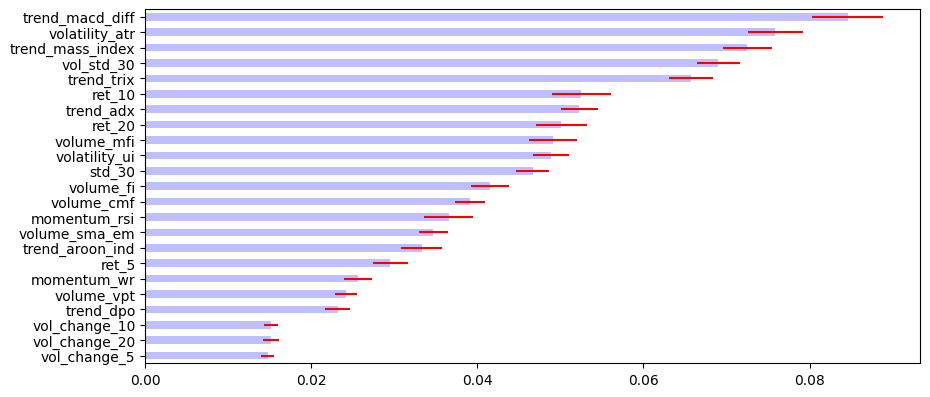

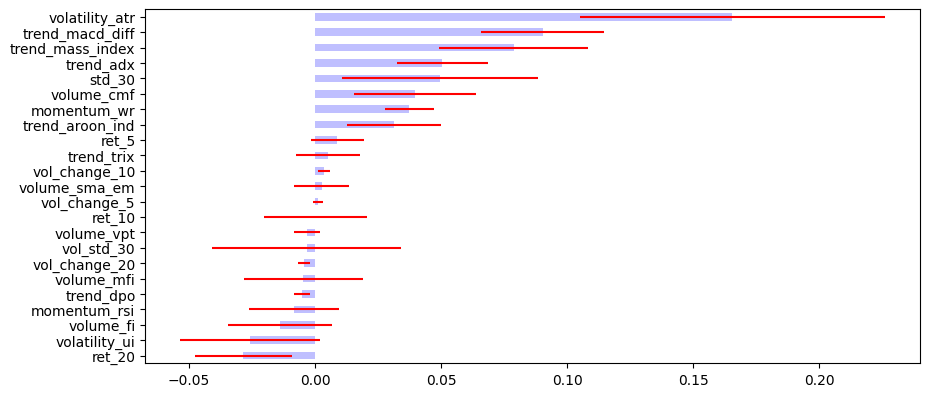

In [28]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

### RFE CV, Recursive Feature Elimination

In [29]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(estimator=svc_rbf, step=1, cv=KFold(5), scoring='accuracy')
rfe_fitted = rfe_cv.fit(X_sc, y)

In [30]:
# 선택된 피쳐 확인하기

selected_features = X.columns[rfe_fitted.support_]

print("Selected features:", selected_features)

Selected features: Index(['volatility_atr', 'trend_macd_diff', 'std_30'], dtype='object')


### SFS, Sequential Feature Selection

In [31]:
# SFS, Sequential Feature Selection

n = 10
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [32]:
# 선택된 피쳐 확인하기

selected_features_sfs = X.columns[sfs_fitted.get_support()]

print("Selected features by SFS:", selected_features_sfs)

Selected features by SFS: Index(['volume_fi', 'volume_mfi', 'trend_macd_diff', 'trend_adx', 'trend_dpo',
       'momentum_rsi', 'vol_change_5', 'ret_5', 'vol_change_10',
       'vol_change_20'],
      dtype='object')


### SHAP, Shapley Additive explanations

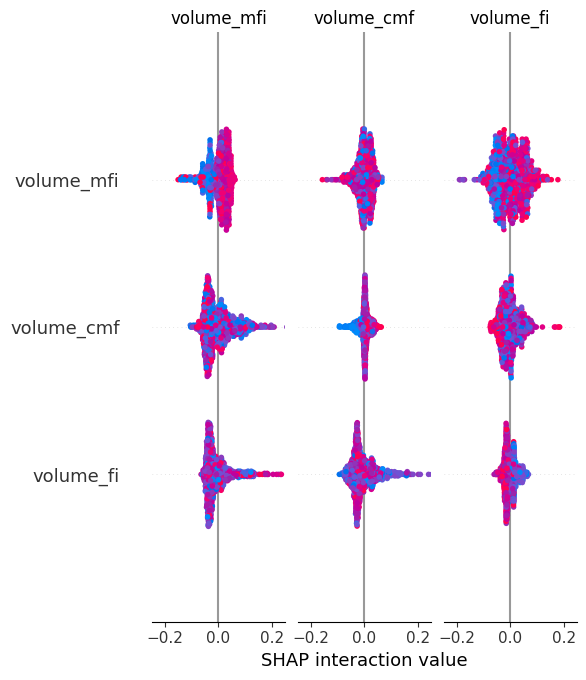

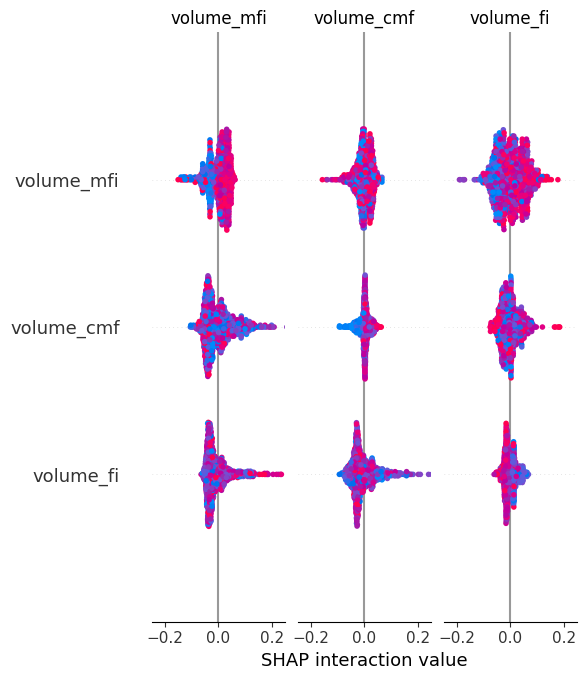

In [33]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc, plot_type="bar")

# 전체 특성의 영향을 시각화
shap.summary_plot(shap_value, X_sc)

# 3.Model Training
- 환경구성 및 데이터 불러오기
- Purged K-fold for Cross-Validation 적용하기
- model 적용하기

- 다양한 방법을 사용해 기존의 결과와 비교 분석 시도해보기
- 다양한 방법 사용하여 성능 향상 시도하기

## 1.환경구성 및 데이터 불러오기

In [34]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/content/drive/MyDrive/Aiffel')
from libs.mlutil.pkfold import PKFold

In [35]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/content/drive/MyDrive/Aiffel'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# 데이터 불러오기
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

## 2.Purged K-fold for Coross-Validation 적용하기

In [36]:
# Q. 코드를 작성해주세요
from libs.mlutil.pkfold import PKFold

n_cv = 4 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_splits=n_cv, samples_info_sets=t1, pct_embargo=0.01)

## 3.Model 적용하기

In [ ]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [ ]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [ ]:
# Bagging 적용
bag_rfc = BaggingClassifier(base_estimator=rfc, n_jobs=-1)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# GridSearchCV 적용
# gs_rfc = GridSearchCV(estimator=bag_rfc, param_grid=bc_params, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2)
gs_rfc = RandomizedSearchCV(estimator=bag_rfc, param_distributions=bc_params, n_iter=50, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2)

In [ ]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=3,
                                                        max_features=None,
                                                        min_samples_leaf=3),
                  bootstrap_features=True, max_features=0.5, n_estimators=5,
                  n_jobs=-1)

In [ ]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall    = recall_score(test_y, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[37 19 23]
 [13 20 24]
 [ 0 14 41]]
정확도:0.5130890052356021, 정밀도:0.5528504395930061, 재현율:0.5130890052356021


In [ ]:
# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

ValueError: multiclass format is not supported

Class 2 does not have both classes present. Skipping.


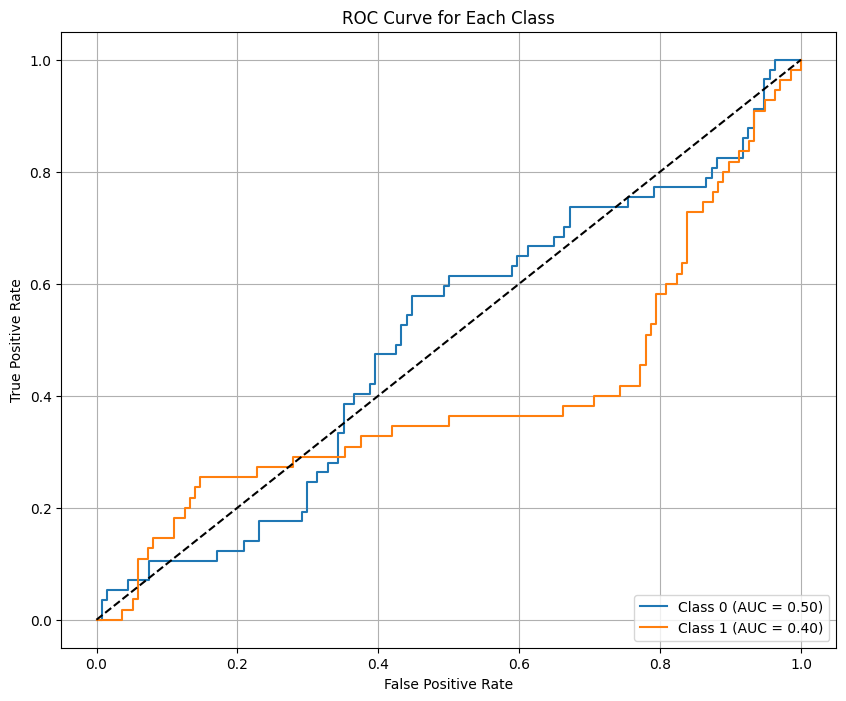

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 클래스 수 설정
n_classes = len(set(test_y))

# 레이블 이진화 (One-vs-Rest 방식으로 다룰 수 있도록)
y_test_binarized = label_binarize(test_y, classes=range(n_classes))

# fpr, tpr, roc_auc 값 저장
fpr = dict()
tpr = dict()
roc_auc = dict()

# 각 클래스에 대해 ROC Curve 및 AUC 계산
for i in range(n_classes):
    # 각 클래스의 예측 확률이 존재하지 않으면 건너뜁니다.
    if np.unique(y_test_binarized[:, i]).size != 2:
        print(f"Class {i} does not have both classes present. Skipping.")
        continue

    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], prob_y[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], prob_y[:, i])

# ROC Curve 시각화
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 2nd try.

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# 데이터 전처리: SMOTE 적용
smote = SMOTE()
train_x_smote, train_y_smote = smote.fit_resample(train_x, train_y)

# 모델 변경: GradientBoostingClassifier 사용
gbc = GradientBoostingClassifier()

# 하이퍼파라미터 설정 및 GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gs_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=2)

# 모델 학습 및 평가
gs_gbc.fit(train_x_smote, train_y_smote)
predictions = gs_gbc.predict(test_x)

# 성능 평가
accuracy = accuracy_score(test_y, predictions)
precision = precision_score(test_y, predictions, average='weighted')
recall = recall_score(test_y, predictions, average='weighted')
cm = confusion_matrix(test_y, predictions)

print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Confusion Matrix:
[[21 19 39]
 [ 4  3 50]
 [ 1  5 49]]
Accuracy: 0.38219895287958117
Precision: 0.4694764981584922
Recall: 0.38219895287958117


## 3rd try.

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# LightGBM 모델 설정
lgbm = LGBMClassifier(class_weight='balanced', n_jobs=-1)

# GridSearchCV에서 사용할 파라미터 설정
lgbm_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 50],
    'max_depth': [-1, 10, 20]
}

# GridSearchCV 적용
gs_lgbm = GridSearchCV(estimator=lgbm, param_grid=lgbm_params, scoring='accuracy', cv=4, n_jobs=-1, verbose=2)

# 모델 학습
gs_lgbm.fit(train_x, train_y)

# 최적의 모델 가져오기
gs_lgbm_best = gs_lgbm.best_estimator_
gs_lgbm_best.fit(train_x, train_y)

# 예측값 확인
pred_y = gs_lgbm_best.predict(test_x)
prob_y = gs_lgbm_best.predict_proba(test_x)

# 평가 지표 계산
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall    = recall_score(test_y, pred_y, average='weighted')

# 결과 출력
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 23
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

## 4th try

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# RandomizedSearchCV에서 사용할 파라미터 설정
bc_params = {'n_estimators': randint(10, 30),
             'max_features': [0.5, 0.7, 1.0],
             'base_estimator__max_depth': randint(5, 20),
             'base_estimator__max_features': [None, 'auto', 'sqrt'],
             'base_estimator__min_samples_leaf': randint(1, 10),
             'bootstrap_features': [False, True]
            }

# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

# Bagging 적용
bag_rfc = BaggingClassifier(base_estimator=rfc, n_jobs=-1, random_state=42)

# RandomizedSearchCV 적용
cv = 5  # KFold split 개수 변경
rs_rfc = RandomizedSearchCV(estimator=bag_rfc, param_distributions=bc_params, n_iter=50, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, random_state=42)

# fit
rs_rfc.fit(train_x, train_y)

# best estimator
rs_rfc_best = rs_rfc.best_estimator_
rs_rfc_best.fit(train_x, train_y)

# 예측값 확인
pred_y = rs_rfc_best.predict(test_x)
prob_y = rs_rfc_best.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall    = recall_score(test_y, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
================= confusion matrix ====================
[[39 11 29]
 [ 8 13 36]
 [ 0  7 48]]
정확도:0.5235602094240838, 정밀도:0.5906766971425151, 재현율:0.5235602094240838


## 5th try

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# 라벨 인코딩
le = LabelEncoder()
train_y_encoded = le.fit_transform(train_y)
test_y_encoded = le.transform(test_y)

# RandomizedSearchCV에서 사용할 파라미터 설정
xgb_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.9),
    'colsample_bytree': uniform(0.6, 0.9)
}

# XGBClassifier 사용
xgb = XGBClassifier(objective='multi:softprob', random_state=42, use_label_encoder=False)

# RandomizedSearchCV 적용
cv = 5  # KFold split 개수
rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=50, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, random_state=42)

# fit
rs_xgb.fit(train_x, train_y_encoded)

# best estimator
rs_xgb_best = rs_xgb.best_estimator_
rs_xgb_best.fit(train_x, train_y_encoded)

# 예측값 확인
pred_y = rs_xgb_best.predict(test_x)
prob_y = rs_xgb_best.predict_proba(test_x)

# test_y_encoded, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y_encoded, pred_y)
accuracy  = accuracy_score(test_y_encoded, pred_y)
precision = precision_score(test_y_encoded, pred_y, average='weighted')
recall    = recall_score(test_y_encoded, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
================= confusion matrix ====================
[[34 10 35]
 [ 9  3 45]
 [ 0  8 47]]
정확도:0.4397905759162304, 정밀도:0.4762424300030802, 재현율:0.4397905759162304


## 6th try

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# 라벨 인코딩
le = LabelEncoder()
train_y_encoded = le.fit_transform(train_y)
test_y_encoded = le.transform(test_y)

# RandomizedSearchCV에서 사용할 파라미터 설정
xgb_params = {
    'n_estimators': randint(50, 300), # n_estimators 범위 확장
    'learning_rate': uniform(0.01, 0.2), # learning_rate 범위 축소
    'max_depth': randint(3, 15), # max_depth 범위 확장
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.3), # gamma 범위 축소
    'subsample': uniform(0.6, 1.0), # subsample 범위 확장
    'colsample_bytree': uniform(0.6, 1.0) # colsample_bytree 범위 확장
}

# XGBClassifier 사용
xgb = XGBClassifier(objective='multi:softprob', random_state=42, use_label_encoder=False)

# RandomizedSearchCV 적용
cv = 5  # KFold split 개수
rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=100, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, random_state=42)

# fit
rs_xgb.fit(train_x, train_y_encoded)

# best estimator
rs_xgb_best = rs_xgb.best_estimator_
rs_xgb_best.fit(train_x, train_y_encoded)

# 예측값 확인
pred_y = rs_xgb_best.predict(test_x)
prob_y = rs_xgb_best.predict_proba(test_x)

# test_y_encoded, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y_encoded, pred_y)
accuracy  = accuracy_score(test_y_encoded, pred_y)
precision = precision_score(test_y_encoded, pred_y, average='weighted')
recall    = recall_score(test_y_encoded, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
================= confusion matrix ====================
[[30 10 39]
 [ 9  2 46]
 [ 0  6 49]]
정확도:0.42408376963350786, 정밀도:0.45662044189042705, 재현율:0.42408376963350786


## 7th try

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# RandomizedSearchCV에서 사용할 파라미터 설정
bc_params = {
    'n_estimators': randint(50, 100),
    'max_features': [0.5, 0.7, 1.0],
    'base_estimator__max_depth': randint(5, 20),
    'base_estimator__max_features': [None, 'auto', 'sqrt'],
    'base_estimator__min_samples_leaf': randint(1, 10),
    'bootstrap_features': [False, True]
}

# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

# ExtraTrees 사용
etc = ExtraTreesClassifier(class_weight='balanced', random_state=42)

# Bagging 적용
bag_rfc = BaggingClassifier(base_estimator=rfc, n_jobs=-1, random_state=42)
bag_etc = BaggingClassifier(base_estimator=etc, n_jobs=-1, random_state=42)

# RandomizedSearchCV 적용
cv = 5  # KFold split 개수
rs_rfc = RandomizedSearchCV(estimator=bag_rfc, param_distributions=bc_params, n_iter=100, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, random_state=42)

# fit
rs_rfc.fit(train_x, train_y)

# best estimator
rs_rfc_best = rs_rfc.best_estimator_
rs_rfc_best.fit(train_x, train_y)

# 예측값 확인
pred_y = rs_rfc_best.predict(test_x)
prob_y = rs_rfc_best.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall    = recall_score(test_y, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


  0%|          | 0/150 [3:05:08<?, ?it/s]


================= confusion matrix ====================
[[40 11 28]
 [12 19 26]
 [ 0  9 46]]
정확도:0.5497382198952879, 정밀도:0.5960128876359243, 재현율:0.5497382198952879


## 8th try

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# RandomizedSearchCV에서 사용할 파라미터 설정
bc_params = {
    'n_estimators': randint(50, 100),
    'max_features': [0.5, 0.7, 1.0],
    'base_estimator__max_depth': randint(5, 20),
    'base_estimator__max_features': [None, 'auto', 'sqrt'],
    'base_estimator__min_samples_leaf': randint(1, 10),
    'bootstrap_features': [False, True]
}

# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

# ExtraTrees 사용
etc = ExtraTreesClassifier(class_weight='balanced', random_state=42)

# Bagging 적용
bag_rfc = BaggingClassifier(base_estimator=rfc, n_jobs=-1, random_state=42)
bag_etc = BaggingClassifier(base_estimator=etc, n_jobs=-1, random_state=42)

# RandomizedSearchCV 적용
cv = 5  # KFold split 개수

# RandomForest 기반 Bagging
rs_rfc = RandomizedSearchCV(estimator=bag_rfc, param_distributions=bc_params, n_iter=100, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, random_state=42)
rs_rfc.fit(train_x, train_y)

# ExtraTrees 기반 Bagging
rs_etc = RandomizedSearchCV(estimator=bag_etc, param_distributions=bc_params, n_iter=100, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, random_state=42)
rs_etc.fit(train_x, train_y)

# 더 나은 성능의 모델 선택
best_model = rs_rfc if rs_rfc.best_score_ > rs_etc.best_score_ else rs_etc

# 최적 모델로 학습 및 평가
best_estimator = best_model.best_estimator_
best_estimator.fit(train_x, train_y)

# 예측값 확인
pred_y = best_estimator.predict(test_x)
prob_y = best_estimator.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall    = recall_score(test_y, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
================= confusion matrix ====================
[[42 15 22]
 [ 9 19 29]
 [ 0  9 46]]
정확도:0.5602094240837696, 정밀도:0.609043687266198, 재현율:0.5602094240837696


# 정리

In [45]:
model_names = [
    'RandomForest', 'Gradient Boosting', 'LGBM', 'RandomForest',
    'XGB', 'XGB', 'RandomForest', 'RandomForest'
]

results = [
    {
        'Model': model_names[i],
        'Accuracy': [0.5130890052356021, 0.38219895287958117, 0.4293193717277487, 0.5235602094240838,
                     0.4397905759162304, 0.42408376963350786, 0.5497382198952879, 0.5602094240837696][i],
        'Precision': [0.5528504395930061, 0.4694764981584922, 0.48364087753243795, 0.5906766971425151,
                      0.4762424300030802, 0.45662044189042705, 0.5960128876359243, 0.609043687266198][i],
        'Recall': [0.5130890052356021, 0.38219895287958117, 0.4293193717277487, 0.5235602094240838,
                   0.4397905759162304, 0.42408376963350786, 0.5497382198952879, 0.5602094240837696][i]
    }
    for i in range(8)
]

df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall
0,RandomForest,0.513089,0.552850,0.513089
1,Gradient Boosting,0.382199,0.469476,0.382199
2,LGBM,0.429319,0.483641,0.429319
3,RandomForest,0.523560,0.590677,0.523560
4,XGB,0.439791,0.476242,0.439791
5,XGB,0.424084,0.456620,0.424084
6,RandomForest,0.549738,0.596013,0.549738
7,RandomForest,0.560209,0.609044,0.560209


- 첫 번째 모델과 동일한 모델을 썼지만 파라미터 설정에 따라 값이 달라지는 결과를 볼 수 있었음